# Testing models

In [1]:
# import pandas & numpy library
import pandas as pd
import numpy as np

# imoprt seaborn & matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# import KNN from sklearn
from sklearn.neighbors import KDTree

# shows a bigger plot size for readability 
plt.rcParams['figure.figsize'] = (12, 5)
#improve resolution
%config InlineBackend.figure_format ='retina'


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score, confusion_matrix

In [2]:
# read 'songDb.tsv' into dataframe with correct encoding  
music = pd.read_csv('songDb.tsv', sep='\t', encoding='ISO-8859-1')

/tmp/ipykernel_218/3079004086.py:2: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  music = pd.read_csv('songDb.tsv', sep='\t', encoding='ISO-8859-1')


# Cleaning and Filtering rows
- gets rid of NaN values
- removes all songs that are not in the top 5 genres
- fixes indexing 
- fixes dtypes

In [3]:
df = music # for testing
df['Genre'].value_counts()

alternativeamericana    1891
electrolatino           1009
doo-wop                  972
reading                  969
nuelectro                909
                        ... 
azeripop                   2
russianelectronic          2
balticfolk                 1
turkishhiphop              1
modernperformance          1
Name: Genre, Length: 625, dtype: int64

In [4]:
df = music # for testing

df = df.rename({'Genre':'genres'}, axis='columns') # rename to match 
df = df.dropna()

# combines subgenres into more general Genres. This function removes all genres outside of the top 5.
# You can alter this to include more than the top 5 genres
def CombineGenre(str_in):

    try:
        str_in = str_in.lower()
        str_in = str_in.strip()
        
        if 'alternativeamericana' in str_in:
            output = 'Alternative'
        elif 'electrolatino' in str_in:
            output = 'Electrolatino'
        elif 'doo-wop' in str_in:
            output = 'Doo-wop'
        elif 'reading' in str_in:
            output = 'Reading'
        elif 'nuelectro' in str_in:
            output = 'Nuelectro'
        else:
            output  = np.nan
    except:
        output = np.nan
        
    return output

# applys above function to combine genres
df['genres'] = df['genres'].apply(CombineGenre)
df = df.dropna() # removes all genres that were not combined before 
df = df.reset_index() # resets the index since we removed many rows
# df # shows now filtered df of music
# df['genres'].value_counts() # shows number of songs in each top 5 genres


In [5]:
feature_cols = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode',
                'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence',
                'Tempo', 'Duration_ms', 'time_signature']

df[feature_cols] = df[feature_cols].astype(np.float64)

# Create Design Matrix and Target vectors from the now filtered Df 

In [6]:
# Start by removing all columns that are not features 

feature_cols = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode',
                'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence',
                'Tempo', 'Duration_ms', 'time_signature']
target_col = 'genres'

X = df[feature_cols]
y = df[target_col]

print(f'Feature cols: {feature_cols}')
print(f'Target: {target_col}')

Feature cols: ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'time_signature']
Target: genres


### Cut down on dimensions

In [7]:
# cut off dimensions to see affect on accuracy
feature_cols = ['Danceability', 'Loudness',
                'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness']

### Sub Sample the data to 10%

In [8]:
# take a subset of the data 10% OR any other subset

full_data = df[feature_cols + [target_col]]
df_small = full_data.groupby('genres').apply(lambda x: x.sample(frac = 1, random_state = 0)).reset_index(
    drop = True)


# This is a small set for testing 
X_small = df_small[feature_cols]
y_small = df_small[target_col]


### Train Test Split

In [9]:
# Create train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, stratify=y_small, test_size=0.2, random_state=42)

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (4600, 6)
Testing shape: (1150, 6)


# Model Tests

### kNN test

In [10]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

# Label encoder for target (fitting it now to avoid unknown classes or different labels in testing)
le = LabelEncoder().fit(df[target_col].unique())

# KNN transformer and classifier
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=20, n_jobs = -1)  # default nn=20, testsize=0.1, frac=0.5, cut features set

# Pipelining
nca_pipe = Pipeline([
    ('nca', nca), 
    ('knn', knn)
])

# Fit
nca_pipe.fit(X_train, le.transform(y_train))

# Preliminary score
print(nca_pipe.score(X_test, le.transform(y_test)))

KeyboardInterrupt: 

### SVM

In [11]:
# SVM code linear
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=50) # default linear            Note: testsize = 0.2, fract 0.99 we get 67.5% 
model.fit(X_train, y_train)

model.score(X_test,y_test)

0.6852173913043478

In [12]:
# SVM code rbf
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='rbf', C=18)                    # 
model.fit(X_train, y_train)

model.score(X_test,y_test)

0.6678260869565218

In [13]:
#from sklearn.model_selection import cross_val_score
#cross_score = cross_val_score(model, X, y, cv=5)

In [14]:
#cross_score

### PCA

### Logistic Regression

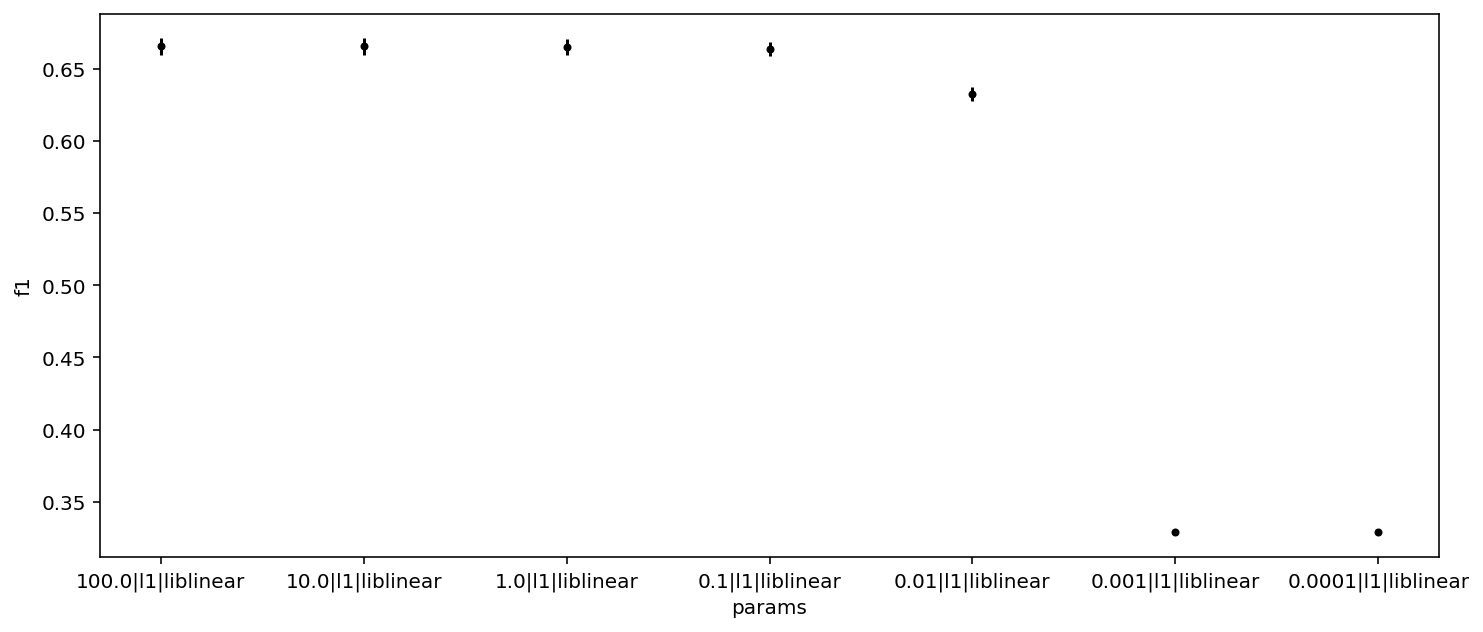

In [15]:
def plot_results(gridsearchcv):
    params = gridsearchcv.cv_results_["params"]
    ys = gridsearchcv.cv_results_["mean_test_score"]
    xs = ['|'.join(str(v) for v in param.values()) for param in params]
    yerr = gridsearchcv.cv_results_["std_test_score"]
    plt.errorbar(xs, ys, yerr / np.sqrt(gridsearchcv.cv), fmt='.k')
    plt.ylabel("f1")
    plt.xlabel("params")
    
def check_for_convergence(gridsearchcv):
    return gridsearchcv.best_estimator_.steps[-1][1].n_iter_ < gridsearchcv.best_estimator_.steps[-1][1].max_iter


np.random.seed(31415) 

scaler = StandardScaler()
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
logistic = LogisticRegression() # first step

# YOUR CODE HERE

pipe = Pipeline(steps=[("scaler", scaler), ("imputer", imp), ("logistic", logistic)])

# you don't need to modify the max_iter param. If you do, keep it under 1000
# hint, prefix your param names with logistic__ to pass it to the logistic step

# this grid when passed to the gridsearch will make a logistic regression 
# if you add more to the param_grid you can compare differnt models and see their IQR
param_grid = { 
    "logistic__C" : 10.0 ** -np.arange(-2, 5),
    "logistic__solver" : ['liblinear'], # use one algo from here it needs to be l1 https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
    "logistic__penalty" : ['l1'] # TA recommends using the l1 penalty 
}

# YOUR CODE HERE

# use f1_micro for scoring
# use 7 folds
gscv = GridSearchCV(pipe, param_grid, scoring = 'f1_micro', cv=7) # GridSearchCV(...)

# YOUR CODE HERE


# gscv.fit(X_train, y_train)
gscv.fit(X_train, y_train)

plot_results(gscv)


### MLP

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(df[target_col].unique())

#Scale and convert data to np array
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(le.transform(y_train))
X_test, y_test = np.array(X_test), np.array(le.transform(y_test))

In [18]:
label_dict = {i:le.inverse_transform([i])[0] for i in range(5)}
#Label dictionary for confusion matrix
label_dict

{0: 'Alternative',
 1: 'Doo-wop',
 2: 'Electrolatino',
 3: 'Nuelectro',
 4: 'Reading'}

In [19]:

# Dataset class to load in data into network
class GenreDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [20]:
# Create Validation test to chec for overfitting
X_train_s, X_val, y_train_s, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=21)

In [21]:
train_dataset = GenreDataset(torch.from_numpy(X_train_s).float(), torch.from_numpy(y_train_s).long())
val_dataset = GenreDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = GenreDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [22]:
# Initalize training parameters
EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 5

In [23]:
# Initalize data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [24]:
# MLP Network

class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512) 
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x) # 1st Layer 
        x = self.batchnorm1(x)
        x = self.relu(x) # ReLU Non Linearization
        
        x = self.layer_2(x) # 2nd Layer 
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x) # Dropout layer, randomly grops values for better accuracy
        
        x = self.layer_3(x) # 3rd layer
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x) # Output layer, will need to softmax while testing

        
        return x

In [25]:
# Check and activate gpu

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [26]:
# Initalize Model and set optimizer and metric

model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=6, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [27]:
# Accuracy Metric

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [28]:
# Dictionaries for plotting training curve

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [29]:
# Start Training

from tqdm import tqdm

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    print("Training...")

    # Set model to train mode
    model.train()

    # Feed model in batches
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        

    print("Validating")    
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        #Stop training model and begin evaluation on validation set
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                                
        
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


  0%|          | 0/30 [00:00<?, ?it/s]

Training...


  0%|          | 0/30 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [ ]:
# Test on test set

y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
# Confusion matrix of test set

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=label_dict, index=label_dict)

sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
# Metrics od model performance of each class 

print(classification_report(y_test, y_pred_list))